# Shallow Classifier to Predictor model discovery using Scikitlearn's `20newsgroups` dataset

# Stage 1: Naive experimentation (no preprocessing, use pre-vectorized data)

## Install Dependencies

In [ ]:
!pipenv install ipykernel==6.28.0
!pipenv install scikit-learn==1.4.1.post1 pandas==2.2.1 matplotlib==3.8.3 seaborn=* python-dotenv==0.19.1

## Import Useful Packages

In [14]:
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import psycopg2

## 1. Pull down the appropriate data

In [7]:
# 1) Pull down the appropriate data

data = fetch_20newsgroups_vectorized(subset='all')
X, y = data.data, data.target

# Note: I have opted NOT to use their pre-split data, as it is done on the arbitrary basis of a time-stamp, which I feel will skew the results.

# 2) Inspect the data
print(X.shape)
print(y.shape)
print(f"Number of classes: {len(data.target_names)}")

# 3) Split it (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(18846, 130107)
(18846,)
Number of classes: 20


## Initial training on a generic Gradient Boost Classifier model

- At first, to get a feel for the way the vectorized data's given features are useful in predicting relative to the classes, I wanted to start off running the unprocessed data through a model with mostly default hyperparameters.

Mean Absolute Error: 0.7787798408488064


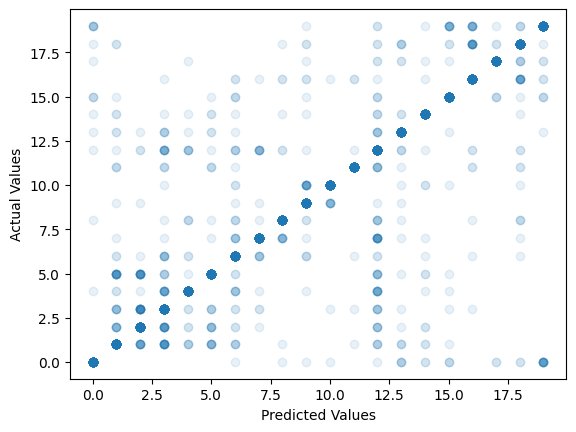

In [9]:
model = XGBClassifier(
    n_estimators=250,  # Rough number of trees to use.
    early_stopping_rounds=5,  # Rounds of no improvement before stopping.
    max_depth=3,  # How deep each tree should go.
    learning_rate=0.1,  # How much each tree should adjust the answer.
    n_jobs=4,  # Parallel processing if available to the computer.
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
)

predictions = model.predict(X_test)

print(
    "Mean Absolute Error: " + str(mean_absolute_error(predictions, y_test))
)
plt.scatter(predictions, y_test, alpha=0.1)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()



*In the above case, Mean Absolute Error has little impact, as the error distance in this case is based on an arbitrary ordering of the categories from 1-20.
To improve the usefulness, it would be better to order the target labels together based on some vectorization and clustering strategy.

In [10]:
# Print Accuracy
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8517241379310345


### Plot confusion matrix

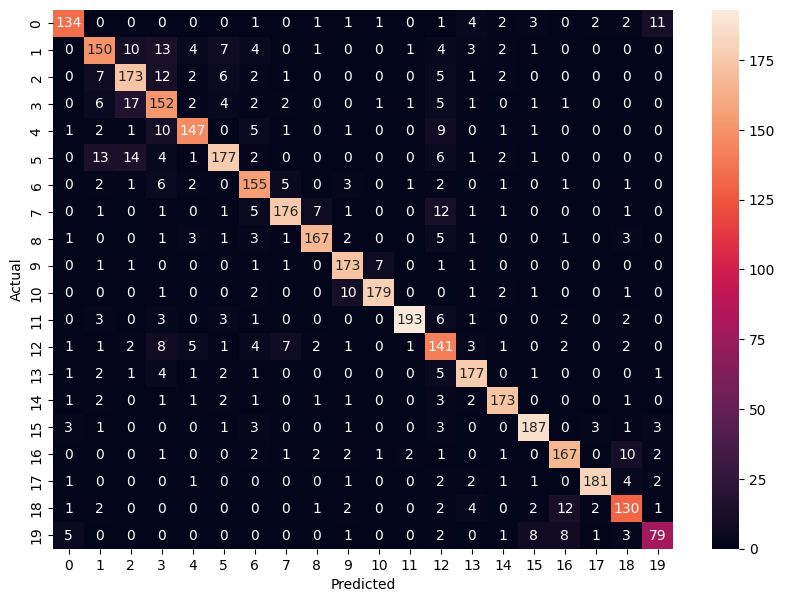

In [11]:
# Plot confusion matrix using seaborn
# A confusion matrix is a chart/table showing the relationship between false positives, false negatives, true positives, and true negatives for a given model's predictions
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Looking closely at the `actual` versus `predicted` categories above, we can see several places where the model had a difficult time distinguishing targets.
- This is likely due to the fact that, if we see the category names, some of them might rightfully be considered sub-categories of the others:

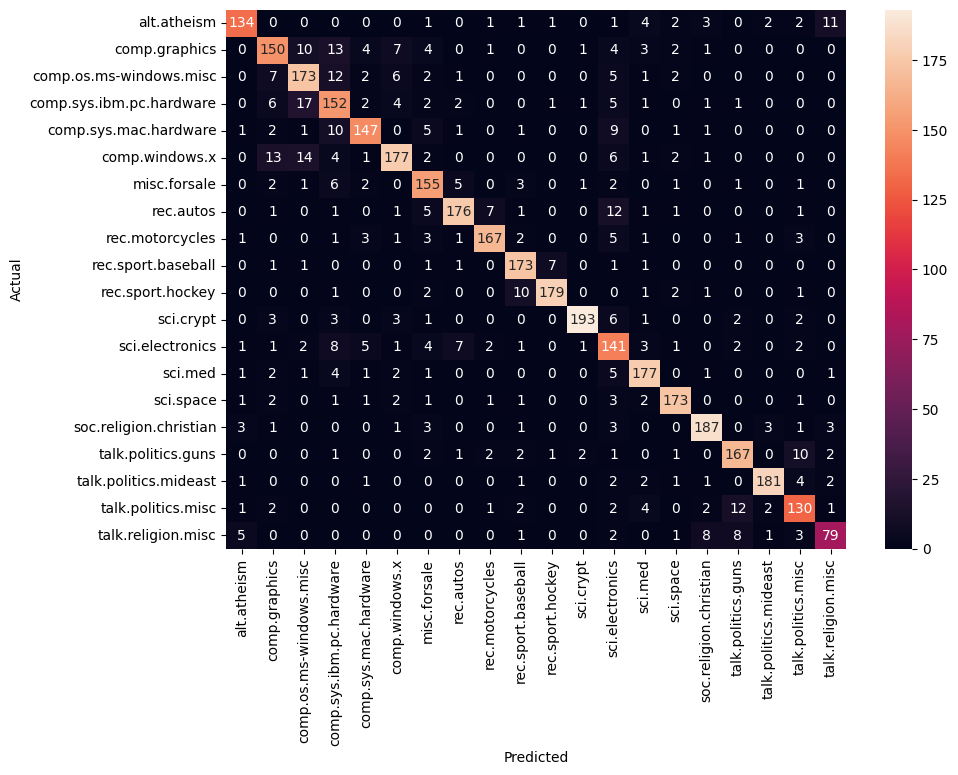

In [12]:
# Print a new confusion matrix, this time with the actual and predicted category labels in place of the numbers
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

As we can see, things like `politics.misc` and `politics.mideast` have a higher rate of confusion for the model; likewise with `autos` and `electronics`, computer hardware and computer operating systems, etc.
We will revisit this after doing some cross validation to see if we can't improve the model further with the given training/testing set.

## Set up hyperparameter tuning matrix

### Experiment with model cross validation using a common scikitlearn tool, `GridSearchCV`

In [15]:
# Set up a hyperparameter grid for the XGBClassifier

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.1, 0.08],
    "max_depth": [3],
}

In [17]:
# Implement GridSearch to iterate over different permutations of hyperparameters
grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=param_grid,
    cv=3, # Number of folds to use for cross-validation
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1, # Use all available cores
)

In [18]:
# Fit the model to each permutation of hyperparameters
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.8min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.8min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.9min
[CV] END ..learning_rate=0.08, max_depth=3, n_estimators=100; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 5.0min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 5.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 5.2min
[CV] END ..learning_rate=0.08, max_depth=3, n_estimators=100; total time= 2.9min
[CV] END ..learning_rate=0.08, max_depth=3, n_estimators=100; total time= 2.9min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time= 7.0min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time= 7.0min
[CV] END ...learning_rate=0.1, max_depth=3, n_est

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.08], 'max_depth': [3],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [19]:
best_parameters = grid_search.best_params_

print(f"Best parameters: {best_parameters}")

best_model = XGBClassifier(**best_parameters)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [20]:
# Now fit the best model to the full set of training data
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.8583554376657825


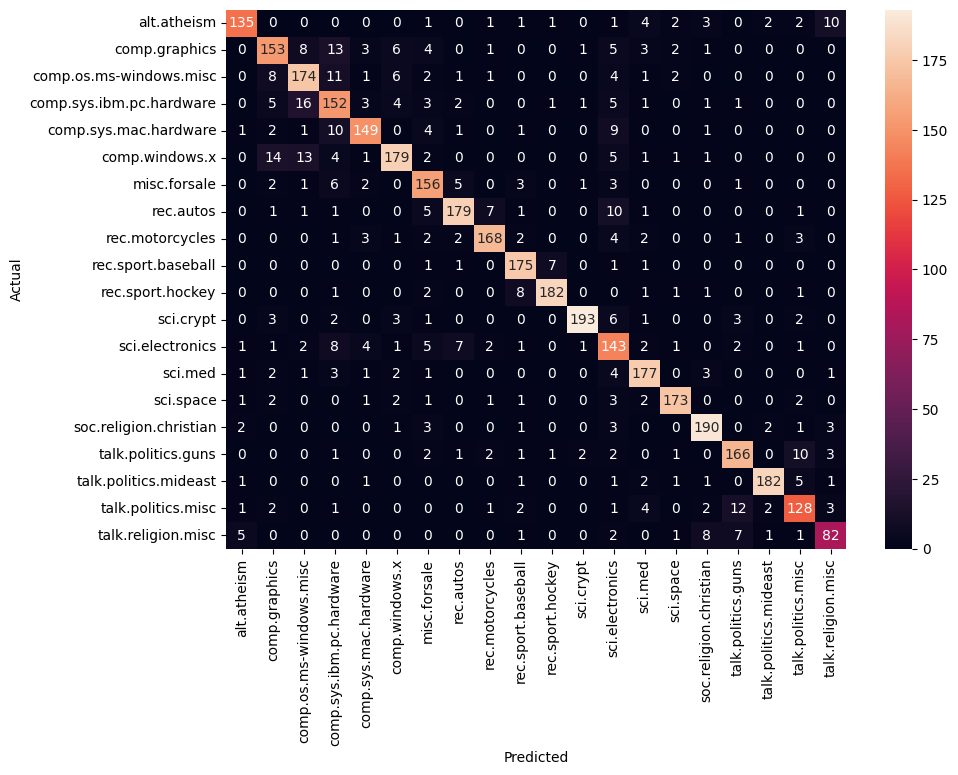

In [21]:
# ...then run it on the test data, print out its accuracy and its confusion matrix with seaborn

predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Finally, the accuracy improved by approximately .4%.

### Considerations and Next Steps

There are several things to consider here:
- As mentioned above, without doing any feature or data engineering, we're stuck with vectorized data that includes metadata which indicates exactly what category the post should go in, and so renders this model inapplicable to most real-world scenarios.
- In both confusion matrices, it's evident that the model struggles (even with the metadata) to distinguish between like- or sub-categories.

To address both of these things, and with the goal of producing a model that can predict categories via live-typing, I will do the following:
1. Pull the pre-vectorized data (text)
2. Pipe it into a CSV file with only `subject` and `body` fields, running some standard text-parsing in the process
3. Re-vectorize the data using the Term Frequency - Inverse Document Frequency (TF-IDF) method to give more realistic weight to the remaining words-as-features.
4. With the strictly relevant, highly cleaned, and newly vectorized data, I will then run several different permutations of hyperparameters via GridSearchCV on the same XGBClassifier model, then train and test the resulting instance.

#### Expectations

I will assume that, because we will no longer possess keywords (vis a vis the headers/footers) which may directly point to the desired labels, the accuracy will drop significantly.
That said, if we're thinking about producing a recommendation feature for #hashtags or #categories in an existing forum, users will be happy to have multiple options based on a ranked-relevance of the target categories that emerge as they are typing. I feel that this form of feature/model is far more useful than something which classifies posts after they've already been posted!

# Stage 2: Text-Data Cleaning, Staging and TF-IDF Vectorization

### Retrieve raw text data from 20NewsGroups

In [30]:
# Import the alternate data set
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

# Retrieve text data
data = fetch_20newsgroups(subset='all')
X, y = data.data, data.target

# Inspect the data
print(X[0])
print(y[0])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


10


### Data Parsing

In [31]:
# Set up a parsing function that takes the list of text blobs, extracts the relevant fields, cleans them, and returns them as a list of strings

import re

def remove_very_common_words(text):
    # Remove very common words
    very_common_words = ['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'i', 'it', 'for', 'not', 'on', 'with', 'he', 'as', 'you', 'do', 'at', 'this', 'but', 'his', 'by', 'from', 'they', 'we', 'say', 'her', 'she', 'or', 'an', 'will', 'my', 'one', 'all', 'would', 'there', 'their', 'what', 'so', 'up', 'out', 'if', 'about', 'who', 'get', 'which', 'go', 'me', 'when', 'make', 'can', 'like', 'time', 'no', 'just', 'him', 'know', 'take', 'people', 'into', 'year', 'your', 'good', 'some', 'could', 'them', 'see', 'other', 'than', 'then', 'now', 'look', 'only', 'come', 'its', 'over', 'think', 'also', 'back', 'after', 'use', 'two', 'how', 'our', 'work', 'first', 'well', 'way', 'even', 'new', 'want', 'because', 'any', 'these', 'give', 'day', 'most', 'us']
    return ' '.join([word for word in text.split() if word.lower() not in very_common_words])

def parse_email_list(email_list, targets):
    parsed_emails = []

    for i, email in enumerate(email_list):
        email_dict = {
            'sender': None,
            'subject': None,
            'organization': None,
            'body': None,
            'target': int(targets[i])  # Convert numpy.int64 to native Python int
        }
        lines = email.split('\n')

        body = ""
        after_lines = False

        for line in lines:

            # Remove special characters
            split_line = re.split(r'[^a-zA-Z0-9:@ ]+', line)

            # Convert to lowercase
            line = ' '.join(split_line).strip().lower()

            if line.startswith('from:'):
                email_dict['sender'] = line[len('from: '):]
            elif line.startswith('subject:'):
                email_dict['subject'] = line[len('subject: '):]
            elif line.startswith('organization:'):
                email_dict['organization'] = line[len('organization: '):]
            elif line.startswith('nntp posting host:'):
                continue
            elif line.startswith('keywords:'):
                continue
            elif line.startswith('lines:'):
                after_lines = True
            elif after_lines:
                body += line + '\n'

        body = body.strip()
        if body:
            body = remove_very_common_words(body)
            email_dict['body'] = body

        parsed_emails.append(email_dict)

    return parsed_emails


### Data staging

Run the parse_email_list function on the data and stage the data into columnar format using Neon database

In [32]:
# Parse the training and test data
parsed_train = parse_email_list(X_train, y_train)
parsed_test = parse_email_list(X_test, y_test)

# Inspect the parsed data
print(parsed_train[0])

{'sender': 'mahan@tgv com  patrick l  mahan', 'subject': 're: is it just me  or is this newsgroup dead', 'organization': 'the internet', 'body': 'to: xpert@expo lcs mit edu rlm@helen surfcty com ve gotten very few posts group last couple days recently added feed list is is group near death seen mailing list side m getting right amount traffic patrick l mahan tgv window washer mahan@tgv com waking person unnecessarily should considered lazarus long capital crime offense is notebooks lazarus long patrick l mahan tgv window washer mahan@tgv com waking person unnecessarily should considered lazarus long capital crime offense is notebooks lazarus long', 'target': 5}


### Set up Neon database

In [33]:
from python-dotenv import load_dotenv

# Establish connection to Neon database using psycopg2

# Load the environment variable using dotenv
NEON_PG_CONNECTION_URL = load_dotenv().get("NEON_PG_CONNECTION_URL")

try:
    connection = psycopg2.connect(NEON_PG_CONNECTION_URL)
    connection.autocommit = True
    print("Connected to Neon Postgres!")
except Exception as e:
    print("Cannot connect to Neon Postgres:", e)

cursor = connection.cursor()

try:
    cursor.execute("""CREATE EXTENSION IF NOT EXISTS vector;""")
except Exception as e:
    print("Cannot create extension pgvector:", e)

Connected to Neon Postgres!


In [34]:
# Create a table to store the parsed email data, including target_labels

target_labels = data.target_names

# Drop the table if it already exists
try:
    cursor.execute("DROP TABLE IF EXISTS email_data;")
except Exception as e:
    print("Cannot drop table email_data:", e)

# Create the table

try:
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS email_data (
            id SERIAL PRIMARY KEY,
            sender TEXT,
            subject TEXT,
            organization TEXT,
            body TEXT,
            target INT,
            target_label TEXT
        );
    """)
except Exception as e:
    print("Cannot create table email_data:", e)

# Insert the parsed email data into the table
for email in parsed_train:
    cursor.execute("""
        INSERT INTO email_data (sender, subject, organization, body, target, target_label)
        VALUES (%s, %s, %s, %s, %s, %s);
    """, (email['sender'], email['subject'], email['organization'], email['body'], email['target'], target_labels[email['target']]))

# Check that the data has been inserted correctly
cursor.execute("SELECT * FROM email_data LIMIT 5;")
rows = cursor.fetchall()
for row in rows:
    print(row)

(1, 'mahan@tgv com  patrick l  mahan', 're: is it just me  or is this newsgroup dead', 'the internet', 'to: xpert@expo lcs mit edu rlm@helen surfcty com ve gotten very few posts group last couple days recently added feed list is is group near death seen mailing list side m getting right amount traffic patrick l mahan tgv window washer mahan@tgv com waking person unnecessarily should considered lazarus long capital crime offense is notebooks lazarus long patrick l mahan tgv window washer mahan@tgv com waking person unnecessarily should considered lazarus long capital crime offense is notebooks lazarus long', 5, 'comp.windows.x')
(2, 'max@queernet org  max j  rochlin', 're: speeding ticket from chp', 'queernet', 'interesting d fight ticket off s 50 50 chance cop won t show secondly does show should point lied purgered ticket why 70 beleive yo re charged going more 15mph posted speed s more severe ticket couldn t p ossibly been going 70 right max@queernet org max j rochlin uunet sgi unpc 

### Vectorize the data using TF-IDF

In [39]:
# Use TF-IDF to vectorize the email data
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize each field separately to allow for different weights
sender_vectorizer = TfidfVectorizer()
subject_vectorizer = TfidfVectorizer()
organization_vectorizer = TfidfVectorizer()
body_vectorizer = TfidfVectorizer()

# Fit the vectorizers to the training data
sender_vectorizer.fit([email['sender'] for email in parsed_train])
subject_vectorizer.fit([email['subject'] for email in parsed_train])
organization_vectorizer.fit([email['organization'] for email in parsed_train])

# Replace all none values with empty strings for all fields 
for email in parsed_train:
    if email['sender'] is None:
        email['sender'] = ''
    if email['subject'] is None:
        email['subject'] = ''
    if email['organization'] is None:
        email['organization'] = ''
    if email['body'] is None:
        email['body'] = ''

# Do the same for the test data
for email in parsed_test:
    if email['sender'] is None:
        email['sender'] = ''
    if email['subject'] is None:
        email['subject'] = ''
    if email['organization'] is None:
        email['organization'] = ''
    if email['body'] is None:
        email['body'] = ''

# Fit the vectorizers to the training data
sender_vectorizer.fit([email['sender'] for email in parsed_train])
subject_vectorizer.fit([email['subject'] for email in parsed_train])
organization_vectorizer.fit([email['organization'] for email in parsed_train])
body_vectorizer.fit([email['body'] for email in parsed_train])

# Transform the training and test data
X_train_sender = sender_vectorizer.transform([email['sender'] for email in parsed_train])
X_train_subject = subject_vectorizer.transform([email['subject'] for email in parsed_train])
X_train_organization = organization_vectorizer.transform([email['organization'] for email in parsed_train])
X_train_body = body_vectorizer.transform([email['body'] for email in parsed_train])

X_test_sender = sender_vectorizer.transform([email['sender'] for email in parsed_test])
X_test_subject = subject_vectorizer.transform([email['subject'] for email in parsed_test])
X_test_organization = organization_vectorizer.transform([email['organization'] for email in parsed_test])
X_test_body = body_vectorizer.transform([email['body'] for email in parsed_test])

# Combine the vectors into a single feature matrix
from scipy.sparse import hstack

X_train = hstack([X_train_sender, X_train_subject, X_train_organization, X_train_body])
X_test = hstack([X_test_sender, X_test_subject, X_test_organization, X_test_body])

### Conduct hyperparameter tuning using GridSearchCV as before, this time with the preprocessed data

In [40]:
# Conduct a grid search to find the best hyperparameters for the XGBClassifier
param_grid = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.1, 0.05],
    "max_depth": [3, 5],
}

grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_

print(f"Best parameters: {best_parameters}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.8min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.8min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time= 2.9min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 5.0min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 5.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 5.1min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 6.5min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 6.5min


/Users/woddeb/.local/share/virtualenvs/mli-2024-07-coursework-GiIGsmvL/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time= 6.5min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=10.8min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=10.8min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=11.0min
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time= 3.1min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=10.5min
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time= 3.1min
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time= 3.1min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=10.5min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=10.5min
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time= 5.7min
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time= 5.7min
[CV] END ..learning_rate=0.0

Accuracy: 0.863395225464191


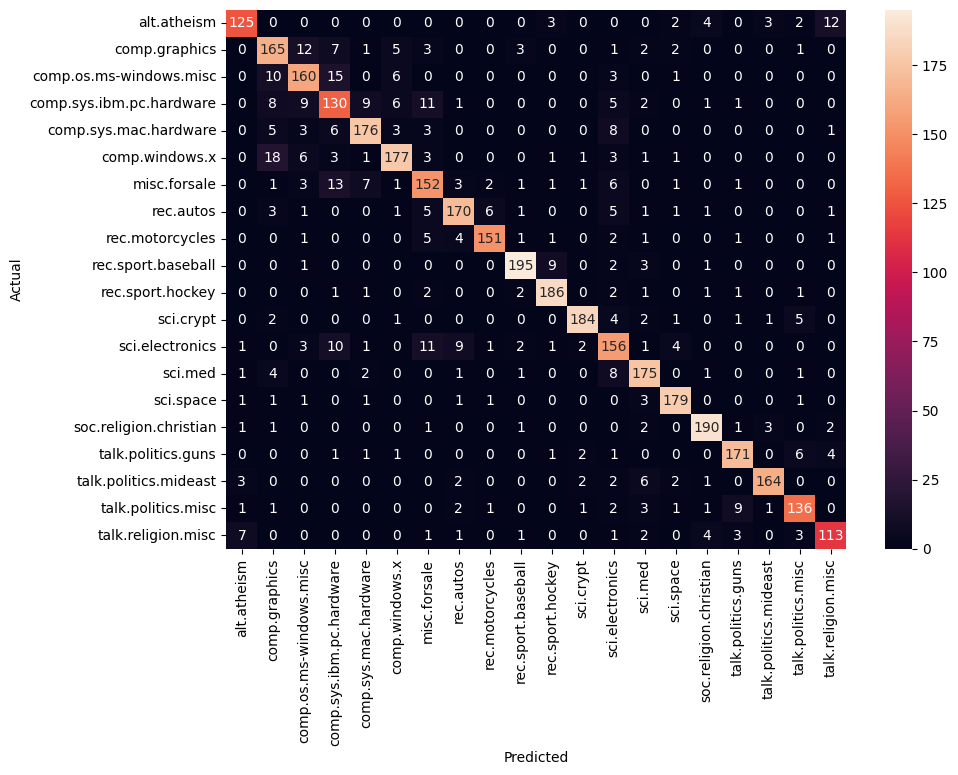

In [41]:
# Fit the best model to the training data
best_model = XGBClassifier(**best_parameters)
best_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = best_model.predict(X_test)

# Print the accuracy, mean absolute error, and confusion matrix
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Conclusions

### Expectations vs. Reality

So, as noted before the beginning of phase 2, I did not expect, once I had trimmed the model of the `keywords` and `nntp_posting_host` values, that I would achieve such a high accuracy, given that these contained overfitting context for the model to predict the corresponding labels. That said, the data I used was fairly carefully cleaned and staged. It seems that the weighting based on text-to-document frequency for individual columnar values had a significant impact.